# Principal Component Analysis (PCA)

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a mechanism for reducing the number of dimensions in data. It enjoys a number of practical applications in machine learning, including obfuscating sensitive or proprietary data, eliminating multicollinearity, removing noise from datasets, and visualizing high-dimensional data by reducing it to two or three dimensions that can be plotted. PCA doesn't directly make machine-learning models more accurate, but it can help them train faster and generalize better. And PCA is easy to perform using Scikit's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class. Let's use it to understand how PCA works and why it can be beneficial in machine learning.

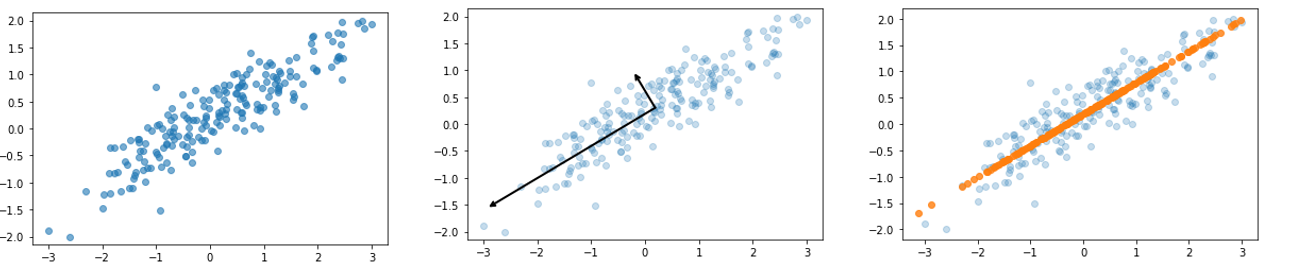

## Understanding PCA

To understand what PCA is and how it works, begin by using it to reduce a 2-dimensional dataset to one dimension. The first step is to generate a dataset consisting of *x* and *y* coordinate pairs that roughly form a line.

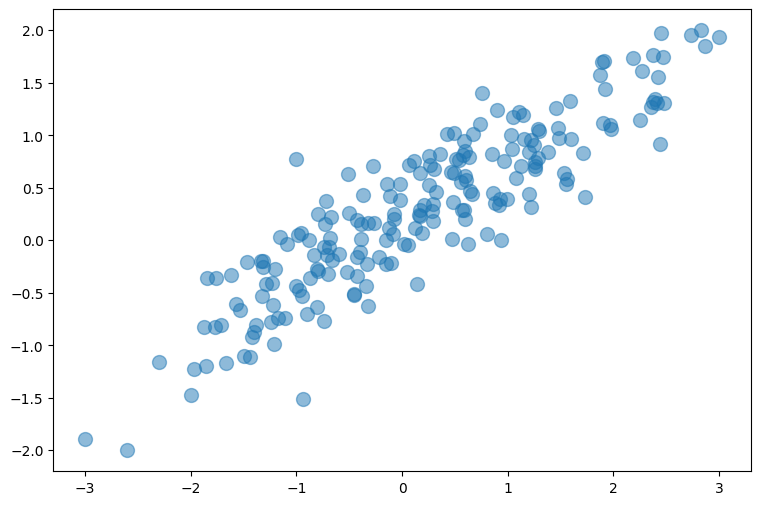

In [ ]:
import numpy as np
from sklearn.datasets import make_regression #generates data for regressions
import matplotlib.pyplot as plt
%matplotlib inline

x, y = make_regression(n_samples=200, n_features=1, noise=50, random_state=0)
x = np.interp(x, (x.min(), x.max()), (-3, 3)) #normalize values in x are scaled to the new range [-3, 3]
y = np.interp(y, (y.min(), y.max()), (-2, 2))
xy = np.column_stack((x, y))

plt.figure(figsize=(9, 6))
plt.scatter(x, y, s=100, alpha=0.5)

Use PCA to find two principal components in the dataset.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(xy)

PCA(n_components=2)

Now plot the two principal components. The primary component is the axis that contains most of the information. The secondary component is the axis that contains the remaining information. Because the data points roughly form a line, the primary component lies along that line.

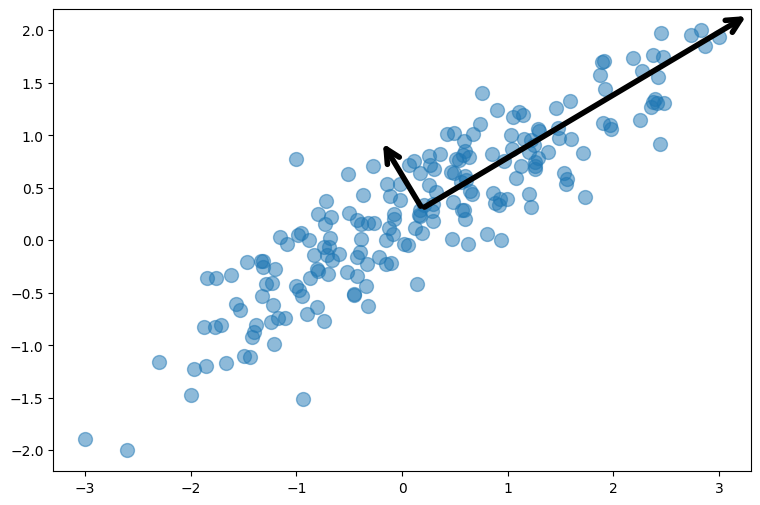

In [ ]:
def draw_vector(v0, v1):
    ax = plt.gca()
    props = dict(arrowstyle='->', linewidth=4, mutation_scale=25) #mutation_scale: Controls the size of the arrowhead
    ax.annotate('', v1, v0, arrowprops=props)

plt.figure(figsize=(9, 6))
plt.scatter(x, y, s=100, alpha=0.5) #s: size; alpha: transparency

#pca.explained_variance_ contains the variance explained by each principal component
#pca.components_ contains the directions (vectors)
#pca.mean_ is the mean of the data along each feature.
for len, vector in zip(pca.explained_variance_, pca.components_):
    draw_vector(pca.mean_, pca.mean_ + (vector * 2.5 * np.sqrt(len)))

**Code explanation**

zip: Combines the explained variance (pca.explained_variance_) and the corresponding principal component vectors (pca.components_) into pairs.

Each pair consists of:

len: The variance explained by the principal component.

vector: The direction of the principal component.


draw_vector is a function (defined earlier) that draws an arrow from one point to another.

The arrow starts at the mean of the data (pca.mean_).

The arrow ends at a point calculated as: pca.mean_ + (vector * 2.5 * np.sqrt(len))
vector: The direction of the principal component.

np.sqrt(len): The square root of the explained variance, which scales the vector proportionally to the variance it explains.

2.5: A scaling factor to make the vectors longer and more visible on the plot.

Use the `PCA` class's `explained_variance_ratio_` attribute to quantify the amount of information contained in each component.

In [ ]:
pca.explained_variance_ratio_

array([0.95860561, 0.04139439])

More than 95% of the information in the dataset is contained in one axis (the primary component). Use PCA to reduce the dataset to one principal component.

In [ ]:
pca = PCA(n_components=1)
pca_data = pca.fit_transform(xy)

Now project all the data points onto the principal component axis by inverting the PCA transform, restoring the transformed data to two dimensions with information from just the first dimension. The original points are shown in blue, while the projected points are shown in orange.

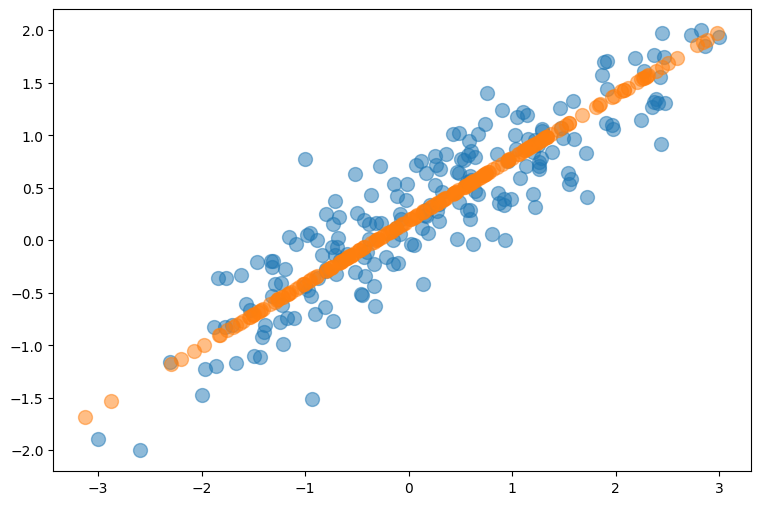

In [ ]:
unpca_data = pca.inverse_transform(pca_data)

plt.figure(figsize=(9, 6))
plt.scatter(x, y, s=100, alpha=0.5)
plt.scatter(unpca_data[:, 0], unpca_data[:, 1], s=100, alpha=0.5)

You can see that the orange points retain most of the information contained in the blue points, even though the size of the dataset has been cut in half (from two dimensions to one). That's the gist of PCA: reducing the number of dimensions without incurring a commensurate loss of information.



---



#PCA on Investments

Principal Component Analysis (PCA) is a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional representation while preserving most of the variance in the original data.

Working: PCA works by finding the directions, or principal components, along which the data varies the most. These principal components are orthogonal to each other, meaning they are uncorrelated. The first principal component captures the maximum amount of variance in the data, followed by the second component, which captures the maximum remaining variance orthogonal to the first, and so on.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from numpy.linalg import eig

# **Understanding data**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/mjha91/data/main/fi8092/investments.csv')
df.head()

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Duration,Invest_Monitor,Expect,Avenue,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Source
0,Female,34,Yes,1,2,5,3,7,6,4,...,1-3 years,Monthly,20%-30%,Mutual Fund,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Fixed Returns,Newspapers and Magazines
1,Female,23,Yes,4,3,2,1,5,6,7,...,More than 5 years,Weekly,20%-30%,Mutual Fund,Health Care,Dividend,Better Returns,Safe Investment,High Interest Rates,Financial Consultants
2,Male,30,Yes,3,6,4,2,5,1,7,...,3-5 years,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Tax Benefits,Assured Returns,Fixed Returns,Television
3,Male,22,Yes,2,1,3,7,6,4,5,...,Less than 1 year,Daily,10%-20%,Equity,Retirement Plan,Dividend,Fund Diversification,Tax Incentives,High Interest Rates,Internet
4,Female,24,No,2,1,3,6,4,5,7,...,Less than 1 year,Daily,20%-30%,Equity,Retirement Plan,Capital Appreciation,Better Returns,Safe Investment,Risk Free,Internet


In [ ]:
df.shape

(40, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   gender                             40 non-null     object
 1   age                                40 non-null     int64 
 2   Investment_Avenues                 40 non-null     object
 3   Mutual_Funds                       40 non-null     int64 
 4   Equity_Market                      40 non-null     int64 
 5   Debentures                         40 non-null     int64 
 6   Government_Bonds                   40 non-null     int64 
 7   Fixed_Deposits                     40 non-null     int64 
 8   PPF                                40 non-null     int64 
 9   Gold                               40 non-null     int64 
 10  Stock_Marktet                      40 non-null     object
 11  Factor                             40 non-null     object
 12  Objective 

In [ ]:
df.describe()

,age,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,27.800000,2.550000,3.475000,5.750000,4.650000,3.575000,2.025000,5.975000
std,3.560467,1.197219,1.131994,1.675617,1.369072,1.795828,1.609069,1.143263
min,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,25.750000,2.000000,3.000000,5.000000,4.000000,2.750000,1.000000,6.000000
50%,27.000000,2.000000,4.000000,6.500000,5.000000,3.500000,1.000000,6.000000
75%,30.000000,3.000000,4.000000,7.000000,5.000000,5.000000,2.250000,7.000000
max,35.000000,7.000000,6.000000,7.000000,7.000000,7.000000,6.000000,7.000000


In [ ]:
df.columns

Index(['gender', 'age', 'Investment_Avenues', 'Mutual_Funds', 'Equity_Market',
       'Debentures', 'Government_Bonds', 'Fixed_Deposits', 'PPF', 'Gold',
       'Stock_Marktet', 'Factor', 'Objective', 'Purpose', 'Duration',
       'Invest_Monitor', 'Expect', 'Avenue',
       'What are your savings objectives?', 'Reason_Equity', 'Reason_Mutual',
       'Reason_Bonds', 'Reason_FD', 'Source'],
      dtype='object')

# **Selecting Features**

In [ ]:
features = df[[#'gender',
    #'age',
    #'Investment_Avenues', 'Mutual_Funds',
    'Equity_Market',
      #
    'Debentures', 'Government_Bonds', 'Fixed_Deposits', 'PPF', 'Gold',
       #'Stock_Marktet', 'Factor', 'Objective',
    #'Purpose', 'Duration'
    ]]
      # 'Invest_Monitor', 'Expect', 'Avenue',
      # 'What are your savings objectives?', 'Reason_Equity', 'Reason_Mutual',
       #'Reason_Bonds', 'Reason_FD', 'Source']

In [ ]:
features.head()

,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold
0,2,5,3,7,6,4
1,3,2,1,5,6,7
2,6,4,2,5,1,7
3,1,3,7,6,4,5
4,1,3,6,4,5,7


# **Applying PCA**

In [ ]:
scaler = StandardScaler()
standardized_features = scaler.fit_transform(features)

In [ ]:
pca = PCA()
principal_components = pca.fit_transform(standardized_features)

# Analyze the principal components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# **Visualization displaying number of features and percent of data its explaining**

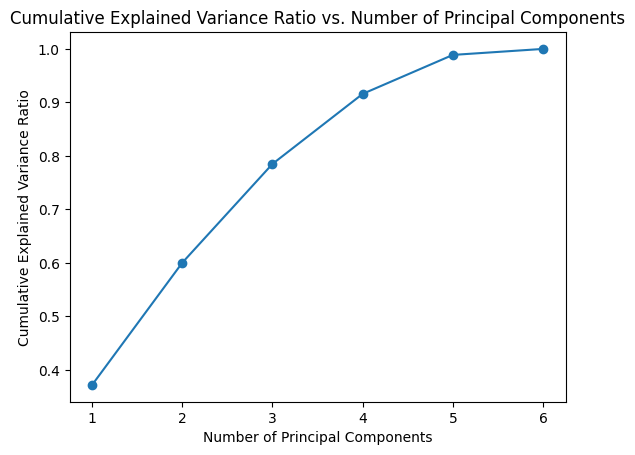

In [ ]:
plt.plot(range(1, explained_variance_ratio.size + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.show()

In [ ]:
threshold = 0.8
num_components_to_retain = cumulative_variance_ratio[cumulative_variance_ratio <= threshold].size
print(num_components_to_retain)

3


# **3 features explains 80% variance in our data**

In [ ]:
selected_principal_components = principal_components[:, :num_components_to_retain]
transformed_data = pd.DataFrame(data=selected_principal_components, columns=[f'PC{i}' for i in range(1, num_components_to_retain + 1)])

In [ ]:
transformed_data.head()

,PC1,PC2,PC3
0,-2.659543,-1.600942,-1.926618
1,-4.252573,-0.013973,0.895386
2,-1.502396,3.082432,0.365657
3,-1.360780,-2.900464,-1.461311
4,-1.817848,-2.787676,0.759354


In [ ]:
loadings = pca.components_[:num_components_to_retain, :]
loadings_df = pd.DataFrame(loadings, columns=features.columns)
print("Loadings of Features on Principal Components:")
print(loadings_df)

Loadings of Features on Principal Components:
   Equity_Market  Debentures  Government_Bonds  Fixed_Deposits       PPF  \
0       0.143261    0.547072          0.494973       -0.464668 -0.425243   
1       0.754956   -0.051475         -0.442359        0.084302 -0.463806   
2       0.061167    0.039208         -0.058218       -0.540285  0.221873   

       Gold  
0 -0.196069  
1  0.097402  
2  0.806348  


**PC1 (Principal Component 1):
Interpretation:**
PC1 has high positive loadings for
..... It has negative loadings for ...

**Potential Interpretation:**
PC1 might represent a combination of ...

PC1 might represent a combination of investment in market-linked securities (Debentures and Government Bonds) versus safe, fixed-income investments (Fixed Deposits and PPF). This suggests that PC1 captures a trade-off between higher-risk, higher-return investments (Debentures and Government Bonds) and lower-risk, lower-return investments (Fixed Deposits and PPF).